Load the LLM, in this case we are using gpt2

In [1]:
#!pip install transformers

In [1]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True, local_files_only = True)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer.eos_token_id).to(device)

In [2]:
#!pip install --upgrade pillow

In [3]:
import sys
sys.path.append("../")

In [3]:
#!pip install ssl

In [4]:
from case_studies.gpt2.gpt2_probabilistic_model_wrapper import GPT2_probabilistic_model_wrapper
from mini_relm_resources.automata_examples.floating_point_wfa import alphabet

wrapper = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer)
#from utilities.mock_probabilistic_model import MockProbabilisticModel
#from pythautomata.base_types.symbol import SymbolStr
#terminal_symbol = SymbolStr(tokenizer.eos_token)
#wrapper = MockProbabilisticModel(alphabet, terminal_symbol)

In [5]:
from mini_relm_resources.automata_examples.floating_point_wfa import get_floating_point_wfa
guiding_wfa = get_floating_point_wfa(wrapper.terminal_symbol)

In [8]:
from utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
guiding_generator = GuidingWDFASequenceGenerator(guiding_wfa, None)
guiding_generator.generate_words(100)

[ϵ,
 .,3,7,8,
 0,
 6,
 3,
 ϵ,
 6,0,8,1,5,
 1,
 7,
 6,2,7,3,
 ϵ,
 .,9,1,
 6,2,6,7,5,6,1,
 7,
 ϵ,
 8,9,9,
 .,5,9,3,
 ϵ,
 6,.,
 .,6,2,9,
 8,3,3,
 ϵ,
 7,
 4,0,2,5,2,
 0,
 ϵ,
 5,5,6,7,8,2,0,2,0,5,9,.,2,
 ϵ,
 ϵ,
 ϵ,
 2,
 ϵ,
 4,5,3,2,
 8,9,
 0,.,9,
 4,9,0,2,4,8,9,
 8,5,4,9,8,
 5,5,
 6,
 ϵ,
 ϵ,
 7,0,
 8,6,
 ϵ,
 0,
 7,6,7,.,
 7,9,7,9,9,.,7,6,6,0,
 6,1,1,9,
 1,2,3,5,.,
 ϵ,
 ϵ,
 2,8,
 4,2,7,7,4,.,4,
 3,
 5,
 0,
 3,8,
 3,0,2,6,0,6,8,9,9,0,1,
 .,
 ϵ,
 9,7,.,4,
 .,1,2,
 5,0,
 4,.,0,
 8,3,
 6,
 3,
 8,.,
 7,7,4,3,.,8,1,6,7,5,
 9,0,.,2,8,6,8,7,5,3,2,
 5,0,9,.,1,8,8,2,6,7,3,4,
 3,4,
 3,
 9,4,
 2,6,
 9,7,
 8,7,0,2,7,9,9,1,1,4,7,3,5,1,3,2,4,
 .,3,
 7,.,
 0,
 ϵ,
 ϵ,
 6,
 9,0,3,7,8,5,0,5,
 7,7,9,3,
 7,9,
 ϵ,
 2,
 5,0,3,
 2,1,
 .,1,3,1,3,1,6,8,0,5,
 6,
 6,9,0,1,4,
 2,5,.,4,
 1,2,2,6,
 7,0,6,1,7,5,0,4,6,
 6,2,
 5,
 .,3,8,3,9,2,7,
 .]

[ϵ,
 .,3,7,8,
 0,
 6,
 3,
 ϵ,
 6,0,8,1,5,
 1,
 7,
 6,2,7,3,
 ϵ,
 .,9,1,
 6,2,6,7,5,6,1,
 7,
 ϵ,
 8,9,9,
 .,5,9,3,
 ϵ,
 6,.,
 .,6,2,9,
 8,3,3,
 ϵ,
 7,
 4,0,2,5,2,
 0,
 ϵ,
 5,5,6,7,8,2,0,2,0,5,9,.,2,
 ϵ,
 ϵ,
 ϵ,
 2,
 ϵ,
 4,5,3,2,
 8,9,
 0,.,9,
 4,9,0,2,4,8,9,
 8,5,4,9,8,
 5,5,
 6,
 ϵ,
 ϵ,
 7,0,
 8,6,
 ϵ,
 0,
 7,6,7,.,
 7,9,7,9,9,.,7,6,6,0,
 6,1,1,9,
 1,2,3,5,.,
 ϵ,
 ϵ,
 2,8,
 4,2,7,7,4,.,4,
 3,
 5,
 0,
 3,8,
 3,0,2,6,0,6,8,9,9,0,1,
 .,
 ϵ,
 9,7,.,4,
 .,1,2,
 5,0,
 4,.,0,
 8,3,
 6,
 3,
 8,.,
 7,7,4,3,.,8,1,6,7,5,
 9,0,.,2,8,6,8,7,5,3,2,
 5,0,9,.,1,8,8,2,6,7,3,4,
 3,4,
 3,
 9,4,
 2,6,
 9,7,
 8,7,0,2,7,9,9,1,1,4,7,3,5,1,3,2,4,
 .,3,
 7,.,
 0,
 ϵ,
 ϵ,
 6,
 9,0,3,7,8,5,0,5,
 7,7,9,3,
 7,9,
 ϵ,
 2,
 5,0,3,
 2,1,
 .,1,3,1,3,1,6,8,0,5,
 6,
 6,9,0,1,4,
 2,5,.,4,
 1,2,2,6,
 7,0,6,1,7,5,0,4,6,
 6,2,
 5,
 .,3,8,3,9,2,7,
 .]

In [26]:
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator
guiding_generator = UniformWordSequenceGenerator(alphabet, 6)

In [27]:
guiding_generator.generate_words(100)

array([5,9,3,6,2, 6,7,1,7,7, .,.,4,8,5, 2,2,.,5, 5,8,6,.,4, 0,9,4,.,1,
       0,0,.,6,1, 4,5,6,1,1, 6,2,0,2,2, 9,8,0,0,7, 5,2,4,1,7, 4,6,7,5,4,
       5,3,.,0,1, 6,.,6,0,7, 7,2,8,8,4, 8,0,1,9,1, 4,4,8,3,2, 0,1,5,4,1,
       9,7,9,2,5, 1,8,.,4,6, 9,2,2,1,7, 5,6,.,3, 3,9,3,., 1,5,0,4,9,
       1,6,.,3,1, 7,6,.,2,4, 4,8,5,6,8, 6,3,1,7,8, .,5,9,1,., 4,9,2,8,5,
       5,1,1,1,0, 1,.,9,6,1, 0,9,3,1, 4,5,6,2,8, 1,5,2,7,., 7,.,.,5,6,
       5,8,1,2,3, 8,4,.,2,5, 3,7,7,6,8, 8,.,7,8,4, 3,3,8,7,7, 8,4,2,4,0,
       5,0,0,9,0, 6,7,8,.,9, 6,6,7,7,5, 0,2,.,.,9, 2,3,8,5,5, 2,5,5,4,6,
       9,0,.,6,1, 8,2,6,9,9, 9,8,9,3,2, 6,5,3,8,5, .,1,4,2,3, 1,0,7,1,0,
       8,5,6,0,1, 2,9,4,4,9, 2,3,0,.,4, 1,9,7,2,2, 3,5,1,5,6, 6,8,9,3,9,
       5,8,3,0,2, 2,.,4,9,4, 7,8,.,5, 6,2,.,7,1, 3,2,6,4,., 1,8,5,7,.,
       5,5,7,2,2, 8,6,.,9,8, 5,9,2,1, 7,8,7,8, 9,9,4,1,3, 3,3,9,9,.,
       0,9,0,1,7, 2,4,3,4,., 8,6,3,9,9, .,0,2,4,7, 2,2,7,5,0, 2,2,7,.,4,
       9,9,9,1,., 6,6,1,6,., 9,.,2,9,9, 7,8,0,3,5, 6,4,.,4,1, 8,.

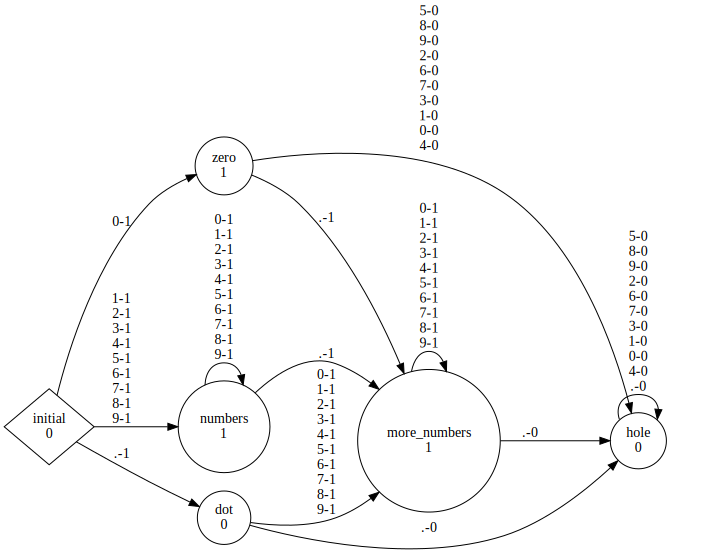

In [10]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(guiding_wfa)

display(graph)

In [28]:
from utilities.syncronic_model_guided_language_model import SyncronicModelGuidedLanguageModel
syncrhronic_model = SyncronicModelGuidedLanguageModel(wrapper, guiding_wfa, model_name="GUIDED_GPT2", max_seq_length=10)

In [29]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
#from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitioner, RankingPartitioner
from utilities.floating_point_partitioner import FloatingPointProbabilityPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator
partitioner = FloatingPointProbabilityPartitioner()
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.05
delta = epsilon
sequence_generator = guiding_generator
max_states = 30
max_query_length = 100


In [30]:
teacher  = PACProbabilisticTeacher(syncrhronic_model, epsilon = epsilon, delta = delta, max_seq_length = None, comparator = comparator, sequence_generator=guiding_generator, compute_epsilon_star=False)
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, None, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = True,  check_probabilistic_hipothesis = False)

In [31]:
learning_result = learner.learn(teacher, verbose=True)

Size before update: 2
CE: 0,4,0,6,5
----update_node----
Old Node (new Leaf) 4,9,3,6,0
New Leaf 0
dict_keys([4,9,3,6,0, ϵ, 0,4])
dict_keys([4,9,3,6,0, ϵ, 0,4, 0])
--------
Size after update: 4
Size before update: 4
CE: .,1,0,.,6
----update_node----
Old Node (new Leaf) 4,9,3,6,0
New Leaf .,1,0
dict_keys([4,9,3,6,0, ϵ, 0,4, 0])
dict_keys([4,9,3,6,0, ϵ, 0,4, 0, .,1,0])
--------
Size after update: 5
Size before update: 5
CE: .,6,9,.,5
----update_node----
Old Node (new Leaf) ϵ
New Leaf .
dict_keys([4,9,3,6,0, ϵ, 0,4, 0, .,1,0])
dict_keys([4,9,3,6,0, ϵ, 0,4, 0, .,1,0, .])
--------
Size after update: 6


In [15]:
from pythautomata.base_types.sequence import Sequence
from pythautomata.base_types.symbol import SymbolStr
test_seq = Sequence([SymbolStr("."),SymbolStr(".")])
#teacher.next_token_probabilities(test_seq)

In [16]:
from collections import OrderedDict
def next_token_probabilities(model, sequence):
        symbols = list(model.alphabet.symbols)
        symbols.sort()
        symbols = [model.terminal_symbol] + symbols
        probabilities = model.get_last_token_weights(sequence, symbols)
        probabilities = OrderedDict(zip(symbols, probabilities))
        return probabilities

In [17]:
from pythautomata.utilities.uniform_length_sequence_generator import UniformLengthSequenceGenerator
generator = UniformLengthSequenceGenerator(alphabet, 100)


In [18]:
import numpy as np
res = list()
words = generator.generate_all_words()
for word in words:
    probs = list(next_token_probabilities(syncrhronic_model, word).values())
    part = partitioner.get_partition(probs)
    print(word, part)
    #if np.sum(probs) > 0:
    #    print(word, part)
    #    res.append((word, probs))
    #if len(res)>1000:
    #    break

ϵ [1]
. [1]
0 [0]
1 [0]
2 [0]
3 [0]
4 [0]
5 [0]
6 [0]
7 [0]
8 [0]
9 [0]
.,. [2]
.,0 [0]
.,1 [0]
.,2 [0]
.,3 [0]
.,4 [0]
.,5 [0]
.,6 [0]
.,7 [0]
.,8 [0]
.,9 [0]
0,. [0]
0,0 [2]
0,1 [2]
0,2 [2]
0,3 [2]
0,4 [2]
0,5 [2]
0,6 [2]
0,7 [2]
0,8 [2]
0,9 [2]
1,. [0]
1,0 [0]
1,1 [0]
1,2 [0]
1,3 [0]
1,4 [0]
1,5 [0]
1,6 [0]
1,7 [0]
1,8 [0]
1,9 [0]
2,. [0]
2,0 [0]
2,1 [0]
2,2 [0]
2,3 [0]
2,4 [0]
2,5 [0]
2,6 [0]
2,7 [0]
2,8 [0]
2,9 [0]
3,. [0]
3,0 [0]
3,1 [0]
3,2 [0]
3,3 [0]
3,4 [0]
3,5 [0]
3,6 [0]
3,7 [0]
3,8 [0]
3,9 [0]
4,. [0]
4,0 [0]
4,1 [0]
4,2 [0]
4,3 [0]
4,4 [0]
4,5 [0]
4,6 [0]
4,7 [0]
4,8 [0]
4,9 [0]
5,. [0]
5,0 [0]
5,1 [0]
5,2 [0]
5,3 [0]
5,4 [0]
5,5 [0]
5,6 [0]
5,7 [0]
5,8 [0]
5,9 [0]
6,. [0]
6,0 [0]
6,1 [0]
6,2 [0]
6,3 [0]
6,4 [0]
6,5 [0]
6,6 [0]
6,7 [0]
6,8 [0]
6,9 [0]
7,. [0]
7,0 [0]
7,1 [0]
7,2 [0]
7,3 [0]
7,4 [0]
7,5 [0]
7,6 [0]
7,7 [0]
7,8 [0]
7,9 [0]
8,. [0]
8,0 [0]
8,1 [0]
8,2 [0]
8,3 [0]
8,4 [0]
8,5 [0]
8,6 [0]
8,7 [0]
8,8 [0]
8,9 [0]
9,. [0]
9,0 [0]
9,1 [0]
9,2 [0]
9,3 [0]
9,4 [0]


KeyboardInterrupt: 

In [ ]:
next_token_probabilities(wrapper, test_seq)

In [ ]:
next_token_probabilities(guiding_wfa, test_seq)

In [ ]:
next_token_probabilities(syncrhronic_model, test_seq)

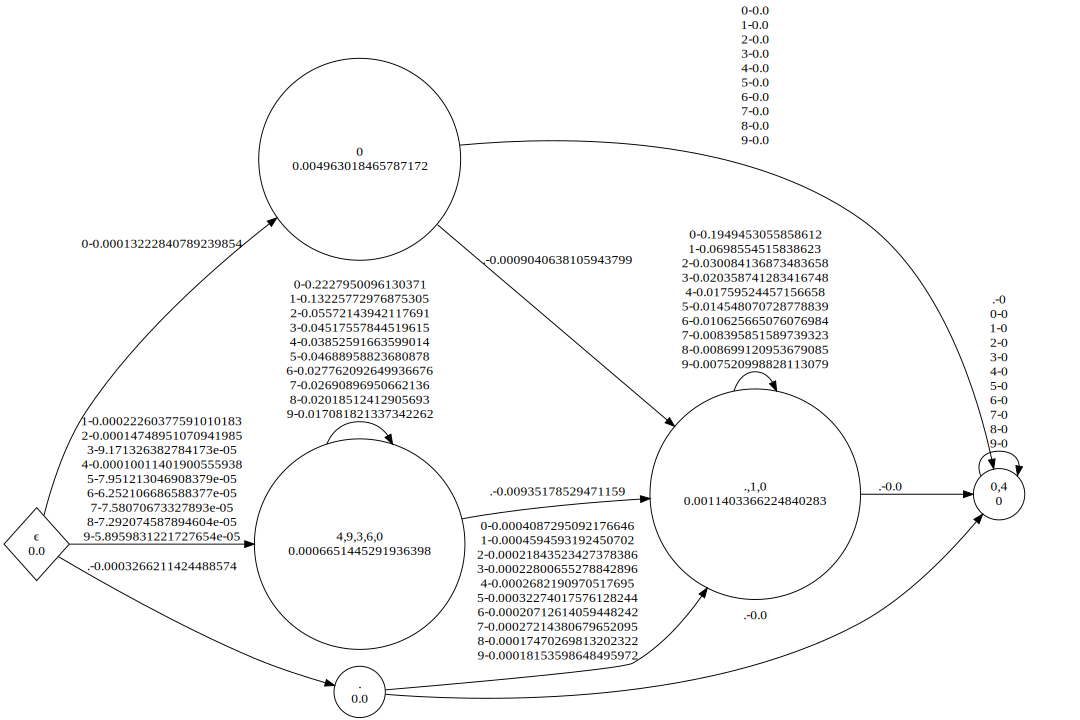

In [32]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(learning_result.model)

display(graph)